In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from statsmodels.tsa.stattools import acf

This figure is a mixture of multiple plots from the book just to give me the opportunity to compare Gibbs sampling to Metropolis. 

In [2]:
theta_1 = 0.5
theta_2 = 0.5
n1 = 8 # Observations n1, n2
n2 = 7
z1 = 6
z2 = 2
n_chain_metropolis = 50000 # Markov chain's length
n_chain_gibbs = 50000
sd = 0.2 # Proposal distribution's standard deviation

In [3]:
trajectory_1 = [0.01]
trajectory_2 = [0.01]
prop_accepted_metropolis = 0
while len(trajectory_1) < n_chain_metropolis:
    new_1 = -1
    new_2 = -1
    while new_1 < 0 or new_1 > 1 or new_2 < 0 or new_2 > 1:
        new_1, new_2 = np.random.multivariate_normal([0,0], [[sd, 0], [0, sd]])
    posterior_1 = beta.pdf(new_1, 1 + z1, 1 + n1 - z1)
    posterior_2 = beta.pdf(new_2, 1 + z2, 1 + n2 - z2)
    posterior_prev_1 = beta.pdf(trajectory_1[-1], 2 + z1, 2 + n1 - z1)
    posterior_prev_2 = beta.pdf(trajectory_2[-1], 2 + z2, 2 + n2 - z2)
    
    p_move = min((posterior_1 * posterior_2) / (posterior_prev_1 * posterior_prev_2), 1)
    
    if np.random.rand(1)[0] < p_move:
        trajectory_1.append(new_1)
        trajectory_2.append(new_2)
        prop_accepted_metropolis = prop_accepted_metropolis + 1
    else:
        trajectory_1.append(trajectory_1[-1])
        trajectory_2.append(trajectory_2[-1])
prop_accepted_metropolis = prop_accepted_metropolis / n_chain_metropolis

In [4]:
z = [z1, z2]
n = [n1, n2]

In [5]:
trajectories = [[0.01], [0.01]]
param = 0
prop_accepted_gibbs = 0
while len(trajectories[0]) < n_chain_gibbs or len(trajectories[1]) < n_chain_gibbs:
    new = -1
    while new < 0 or new > 1:
        new = trajectories[param][-1] + np.random.normal(0, sd)
    posterior = beta.pdf(new, z[param] + 2, n[param] - z[param] + 2)
    posterior_prev = beta.pdf(trajectories[param][-1], z[param] + 1, n[param] - z[param] + 1)
    
    p_move = min(posterior / posterior_prev, 1)
    
    if np.random.rand(1)[0] < p_move:
        trajectories[param].append(new)
        prop_accepted_gibbs = prop_accepted_gibbs + 1
    else:
        trajectories[param].append(trajectories[param][-1])
        
    param = (param + 1) % 2 
prop_accepted_gibbs = prop_accepted_gibbs / (2 * n_chain_gibbs)

In [6]:
def calculate_ess(trajectory):
    nlags = 30
    acf_k = np.empty(0)
    while acf_k.shape[0] < 1:
        nlags = nlags + 10
        acf_k = acf(trajectory, nlags = nlags)
        acf_k = acf_k[acf_k >= 0.05]
    return len(trajectory) / (1 + 2 * np.sum(acf_k))

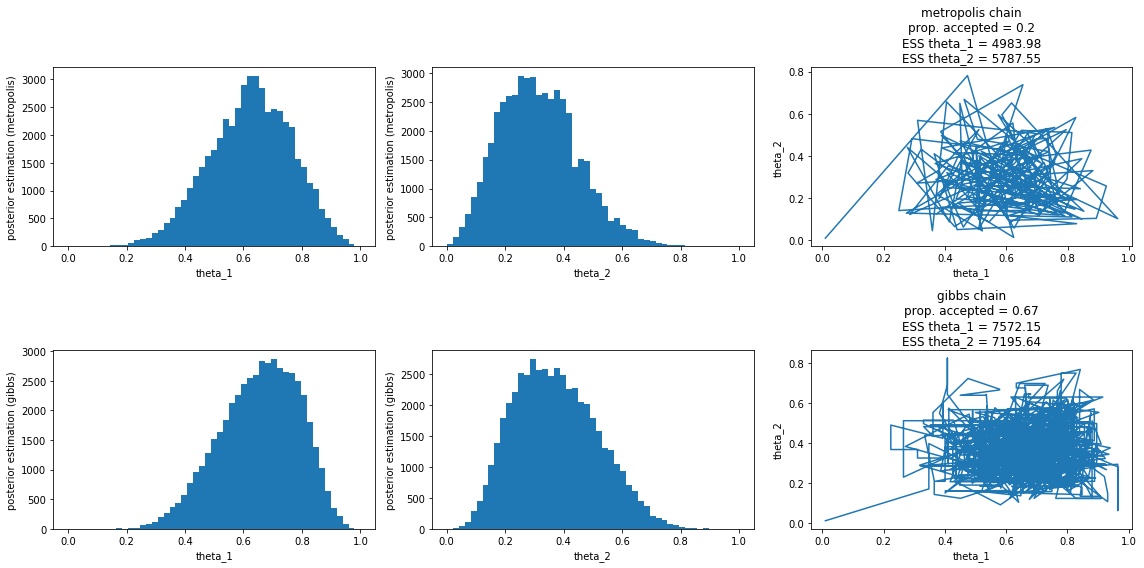

In [7]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].hist(trajectory_1, bins = np.linspace(0, 1, 50))
ax[0, 0].set_xlabel('theta_1')
ax[0, 0].set_ylabel('posterior estimation (metropolis)')
ax[0, 1].hist(trajectory_2, bins = np.linspace(0, 1, 50))
ax[0, 1].set_xlabel('theta_2')
ax[0, 1].set_ylabel('posterior estimation (metropolis)')
ax[0, 2].plot(trajectory_1[:1000], trajectory_2[:1000])
ax[0, 2].set_xlabel('theta_1')
ax[0, 2].set_ylabel('theta_2')
ax[0, 2].set_title('metropolis chain\nprop. accepted = ' + \
                   str(round(prop_accepted_metropolis, 2)) + \
                   '\nESS theta_1 = ' + \
                   str(round(calculate_ess(trajectory_1), 2)) +
                   '\nESS theta_2 = ' + \
                   str(round(calculate_ess(trajectory_2), 2)))
ax[1, 0].hist(trajectories[0], bins = np.linspace(0, 1, 50))
ax[1, 0].set_xlabel('theta_1')
ax[1, 0].set_ylabel('posterior estimation (gibbs)')
ax[1, 1].hist(trajectories[1], bins = np.linspace(0, 1, 50))
ax[1, 1].set_xlabel('theta_2')
ax[1, 1].set_ylabel('posterior estimation (gibbs)')
ax[1, 2].plot(trajectories[0][:1000], trajectories[1][:1000])
ax[1, 2].set_xlabel('theta_1')
ax[1, 2].set_ylabel('theta_2')
ax[1, 2].set_title('gibbs chain\nprop. accepted = ' + \
                   str(round(prop_accepted_gibbs, 2)) + \
                   '\nESS theta_1 = ' + \
                   str(round(calculate_ess(trajectories[0]), 2)) +
                   '\nESS theta_2 = ' + \
                   str(round(calculate_ess(trajectories[1]), 2)))
fig.set_figwidth(16)
fig.set_figheight(8)
plt.tight_layout()

Showing only the first 1000 steps.